<a href="https://colab.research.google.com/github/amalsalilan/Electricity_Demand-and_Price_ForecastingInfosys_Internship_Oct2025/blob/poojitha/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmpje50cd4_/9ktsi57d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpje50cd4_/5zpvcgzh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57502', 'data', 'file=/tmp/tmpje50cd4_/9ktsi57d.json', 'init=/tmp/tmpje50cd4_/5zpvcgzh.json', 'output', 'file=/tmp/tmpje50cd4_/prophet_modelj10u_rlu/prophet_model-20250313115601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:56:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:56:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


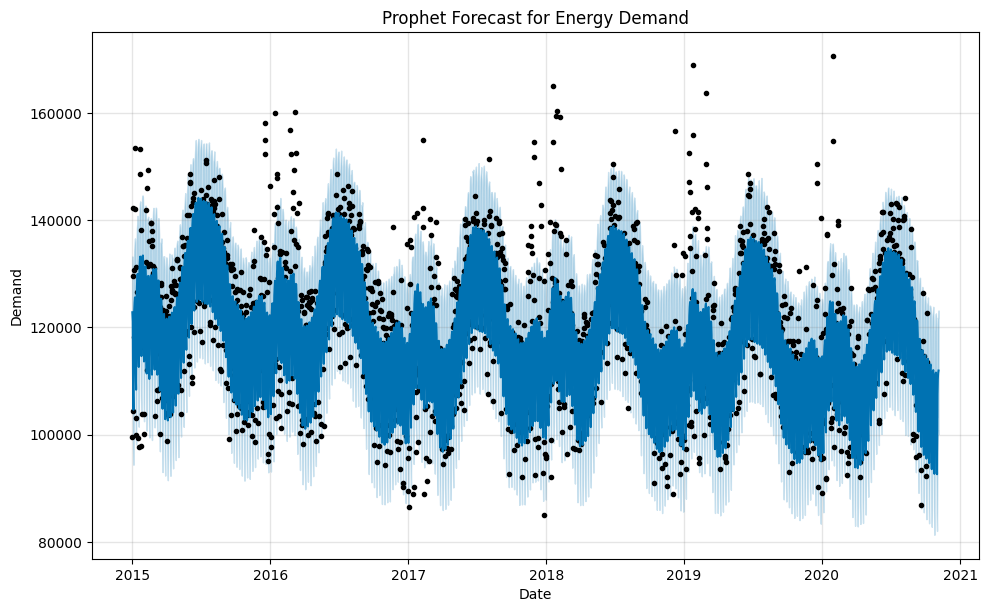

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2131,2020-11-01,114439.707149,82024.730029,103198.932463,114432.727621,114442.346248,-21837.467315,-21837.467315,-21837.467315,-13051.082860,-13051.082860,-13051.082860,-8786.384455,-8786.384455,-8786.384455,0.0,0.0,0.0,92602.239834
2132,2020-11-02,114434.017695,96095.928521,119608.351060,114426.497771,114437.229475,-6927.277447,-6927.277447,-6927.277447,1796.387443,1796.387443,1796.387443,-8723.664890,-8723.664890,-8723.664890,0.0,0.0,0.0,107506.740249
2133,2020-11-03,114428.328242,99258.698209,121848.431920,114419.936100,114432.264699,-4069.976973,-4069.976973,-4069.976973,4576.734604,4576.734604,4576.734604,-8646.711577,-8646.711577,-8646.711577,0.0,0.0,0.0,110358.351269
2134,2020-11-04,114422.638788,100832.724290,121687.259650,114413.420631,114427.223091,-2920.965432,-2920.965432,-2920.965432,5635.922646,5635.922646,5635.922646,-8556.888078,-8556.888078,-8556.888078,0.0,0.0,0.0,111501.673356
2135,2020-11-05,114416.949334,100148.713042,123172.972796,114406.735107,114422.931201,-2458.768303,-2458.768303,-2458.768303,5996.852732,5996.852732,5996.852732,-8455.621035,-8455.621035,-8455.621035,0.0,0.0,0.0,111958.181031


In [ ]:
# Import necessary libraries
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load the preprocessed dataset
file_path = "processed_dataset.csv"
df = pd.read_csv(file_path)

# Ensure correct column names for Prophet ('ds' for date, 'y' for target variable)
df.rename(columns={'date': 'ds', 'demand': 'y'}, inplace=True)

# Convert 'ds' to datetime format
df['ds'] = pd.to_datetime(df['ds'])

# Initialize and fit the Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(df)

# Create future dataframe (next 30 days)
future = model.make_future_dataframe(periods=30, freq='D')

# Forecast
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
plt.title("Prophet Forecast for Energy Demand")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.show()

# Save forecast results
forecast.to_csv("prophet_forecast.csv", index=False)

# Display last few rows of forecast
forecast.tail()


In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load the processed dataset
file_path = "processed_dataset.csv"
df = pd.read_csv(file_path)

# Rename the 'date' column to 'ds' and 'demand' to 'y'
df.rename(columns={'date': 'ds', 'demand': 'y'}, inplace=True)

# Ensure the date column is in datetime format
df['ds'] = pd.to_datetime(df['ds'])

# Convert 'holiday' column to numeric representation (e.g., 1 for holiday, 0 for non-holiday)
# Assuming 'Y' represents holiday and other values represent non-holiday
df['holiday'] = df['holiday'].apply(lambda x: 1 if x == 'Y' else 0)

# Splitting dataset into train (80%) and test (20%)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Initializing the Prophet model
model = Prophet()

# Adding additional regressors if present
regressors = ['temperature', 'weekday', 'holiday']
available_regressors = [col for col in regressors if col in df.columns]

for reg in available_regressors:
    model.add_regressor(reg)

# Fit the model
model.fit(train[['ds', 'y'] + available_regressors])

# Creating future dataframe
future = model.make_future_dataframe(periods=len(test), freq='D')

# Adding regressors to the future dataframe
# Instead of merging, fill 'holiday' based on the original dataframe
future['holiday'] = future['ds'].apply(lambda x: df.loc[df['ds'] == x, 'holiday'].iloc[0] if x in df['ds'].values else 0)  # Fill with 0 for future dates not in original data



# Forecasting
forecast = model.predict(future)

# Extracting relevant predictions
forecasted_values = forecast[['ds', 'yhat']].iloc[-len(test):]
test_values = test[['ds', 'y']]

# Calculate performance metrics
mae = mean_absolute_error(test_values['y'], forecasted_values['yhat'])
rmse = np.sqrt(mean_squared_error(test_values['y'], forecasted_values['yhat']))


# Calculate MAPE
mape = np.mean(np.abs((test_values['y'] - forecasted_values['yhat']) / test_values['y'])) * 100

print(f"MAPE: {mape:.2f}%")




# Output results
mae, rmse,mape

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpje50cd4_/ay6ne46h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpje50cd4_/nxvzhg56.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21766', 'data', 'file=/tmp/tmpje50cd4_/ay6ne46h.json', 'init=/tmp/tmpje50cd4_/nxvzhg56.json', 'output', 'file=/tmp/tmpje50cd4_/prophet_model8z1b7gmn/prophet_model-20250313115605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:56:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:56:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE: 5.73%


(6578.484412935377, 8555.004464872705, 5.726110109914248)

In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Reload the dataset to ensure correct processing
df = pd.read_csv("processed_dataset.csv")

# Rename the 'date' column to 'ds' if necessary
if 'date' in df.columns:
    df.rename(columns={'date': 'ds'}, inplace=True)
# Rename the demand column to 'y'
if 'demand' in df.columns:
    df.rename(columns={'demand': 'y'}, inplace=True)
# Convert the date column to datetime format
df['ds'] = pd.to_datetime(df['ds'])

# Handle missing values (NaN) in regressors and convert 'holiday' to numeric:
# 1. Fill NaN values in numerical columns with 0 (or another imputation method)
# 2. Convert 'holiday' to numeric (1 for holiday, 0 for non-holiday)
df.fillna(0, inplace=True)  # Fill all NaNs with 0

# Assuming 'holiday' column contains 'Y' for holiday and other values for non-holiday
df['holiday'] = df['holiday'].apply(lambda x: 1 if x == 'Y' else 0) # Convert 'holiday' to numeric

  # Get the list of available columns in the dataframe
available_columns = df.columns.tolist()

# Filter the desired regressors to include only those that are available
desired_regressors = ['school_day', 'holiday', 'temperature', 'weekday', 'solar_exposure']
regressors_to_convert = [col for col in desired_regressors if col in available_columns]

# Convert the selected regressors to numeric
for col in regressors_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)



# Splitting the data into training and testing sets (80%-20% split)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Prophet Model Without Regressors
model_no_reg = Prophet()
model_no_reg.fit(train[['ds', 'y']])

# Creating future dataframe and making predictions
future_no_reg = model_no_reg.make_future_dataframe(periods=len(test), freq='D')
forecast_no_reg = model_no_reg.predict(future_no_reg)

# Extract predictions and actual values
y_pred_no_reg = forecast_no_reg['yhat'].iloc[-len(test):].values
y_true = test['y'].values

# Compute error metrics for Prophet without regressors
mse_no_reg = mean_squared_error(y_true, y_pred_no_reg)
rmse_no_reg = np.sqrt(mse_no_reg)
mape_no_reg = mean_absolute_percentage_error(y_true, y_pred_no_reg)

# Identifying potential regressors in the dataset
regressors = [col for col in df.columns if col not in ['ds', 'y']]

# Prophet Model With Regressors (if available)
# Ensure all regressors are numeric before fitting:
for reg in regressors:
    train[reg] = pd.to_numeric(train[reg], errors='coerce')  # Convert to numeric, handle errors
    test[reg] = pd.to_numeric(test[reg], errors='coerce')   # Convert to numeric, handle errors

if regressors:
    model_with_reg = Prophet()
    for reg in regressors:
        model_with_reg.add_regressor(reg)

    model_with_reg.fit(train)

    future_with_reg = model_with_reg.make_future_dataframe(periods=len(test), freq='D')
    future_with_reg = future_with_reg.merge(df[['ds'] + regressors], on='ds', how='left').fillna(method='ffill')

    forecast_with_reg = model_with_reg.predict(future_with_reg)

    y_pred_with_reg = forecast_with_reg['yhat'].iloc[-len(test):].values

    mse_with_reg = mean_squared_error(y_true, y_pred_with_reg)
    rmse_with_reg = np.sqrt(mse_with_reg)
    mape_with_reg = mean_absolute_percentage_error(y_true, y_pred_with_reg)
else:
    mse_with_reg, rmse_with_reg, mape_with_reg = None, None, None


# Output the calculated metrics
{
    "Without Regressors": {"MSE": mse_no_reg, "RMSE": rmse_no_reg, "MAPE": mape_no_reg},
    "With Regressors": {"MSE": mse_with_reg, "RMSE": rmse_with_reg, "MAPE": mape_with_reg},
}



INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpje50cd4_/k6ebpkkp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpje50cd4_/v3iwx68v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90303', 'data', 'file=/tmp/tmpje50cd4_/k6ebpkkp.json', 'init=/tmp/tmpje50cd4_/v3iwx68v.json', 'output', 'file=/tmp/tmpje50cd4_/prophet_model83d997us/prophet_model-20250313115612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:56:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:56:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-7-48d41c134c53>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

{'Without Regressors': {'MSE': 77620713.0534148,
  'RMSE': 8810.261803908827,
  'MAPE': 0.05822810089693308},
 'With Regressors': {'MSE': 117.97729769695617,
  'RMSE': 10.861735482737377,
  'MAPE': 7.318434906749077e-05}}

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpje50cd4_/_d7jejui.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpje50cd4_/44mwipzu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79936', 'data', 'file=/tmp/tmpje50cd4_/_d7jejui.json', 'init=/tmp/tmpje50cd4_/44mwipzu.json', 'output', 'file=/tmp/tmpje50cd4_/prophet_model6usmtnfz/prophet_model-20250313115622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:56:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:56:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-8-1f95cb462af8>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

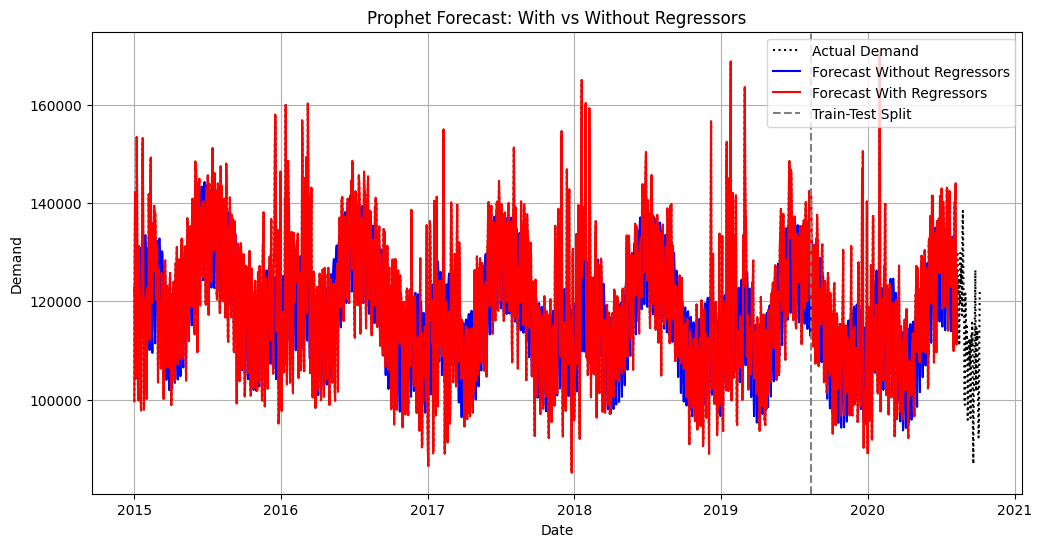

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

# Load the dataset
file_path = "processed_dataset.csv"
df = pd.read_csv(file_path)

# Rename columns for Prophet
df.rename(columns={'date': 'ds', 'demand': 'y'}, inplace=True)
df['ds'] = pd.to_datetime(df['ds'])

# Handle missing values and convert 'holiday' to numeric BEFORE splitting
df = df.replace(['N', 'NAN', 'nan', 'n/a'], np.nan)  # Add other variations as needed
df.fillna(0, inplace=True)  # Fill all NaNs with 0
df['holiday'] = df['holiday'].apply(lambda x: 1 if x == 'Y' else 0)

# Split into training and testing sets (80-20 split)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Prophet model without regressors
model_no_reg = Prophet()
model_no_reg.fit(train)

# Forecasting for the next 1 year
future_no_reg = model_no_reg.make_future_dataframe(periods=365, freq='D')
forecast_no_reg = model_no_reg.predict(future_no_reg)

# Prophet model with regressors (if available)
regressors = [col for col in df.columns if col not in ['ds', 'y']]
if regressors:
    model_with_reg = Prophet()
    for reg in regressors:
        model_with_reg.add_regressor(reg)

    # Ensure all regressors are numeric in the training data:
    for reg in regressors:
        train[reg] = pd.to_numeric(train[reg], errors='coerce').fillna(0) # Convert to numeric & fill NaNs

    model_with_reg.fit(train)

    # Prepare future dataframe with regressors
    future_with_reg = model_with_reg.make_future_dataframe(periods=365, freq='D')

    # Explicitly convert 'holiday' to numeric in future_with_reg:
    future_with_reg['holiday'] = future_with_reg['ds'].apply(lambda x: df.loc[df['ds'] == x, 'holiday'].iloc[0] if x in df['ds'].values else 0)

    # Merge with all regressors and fill missing values:
    future_with_reg = future_with_reg.merge(df[['ds'] + regressors], on='ds', how='left').fillna(method='ffill')

    # Convert all regressor columns in future_with_reg to numeric:
    for reg in regressors:
        # Check if the column exists before converting:
        if reg in future_with_reg.columns:
            future_with_reg[reg] = pd.to_numeric(future_with_reg[reg], errors='coerce').fillna(0)

    # Ensure 'holiday' is in the future_with_reg dataframe with the correct name
    if 'holiday' not in future_with_reg.columns:
        # If 'holiday' is missing, try to find a similar column (e.g., 'holiday_Y') and rename it
        holiday_cols = [col for col in future_with_reg.columns if 'holiday' in col]
        if holiday_cols:
            future_with_reg.rename(columns={holiday_cols[0]: 'holiday'}, inplace=True)
        else:
            # If no similar column is found, raise an informative error
            raise ValueError("No 'holiday' or similar column found in the future dataframe. Please check your data.")

    forecast_with_reg = model_with_reg.predict(future_with_reg)

# Plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label="Actual Demand", color="black", linestyle="dotted")
plt.plot(forecast_no_reg['ds'], forecast_no_reg['yhat'], label="Forecast Without Regressors", color="blue")
if regressors:
    plt.plot(forecast_with_reg['ds'], forecast_with_reg['yhat'], label="Forecast With Regressors", color="red")

plt.axvline(df['ds'].iloc[train_size], color='gray', linestyle="--", label="Train-Test Split")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("Prophet Forecast: With vs Without Regressors")
plt.legend()
plt.grid(True)
plt.show()

FOR NEXT YEAR(2022)***italicized text***

In [ ]:
!mkdir -p /mnt/data

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpje50cd4_/m3x0_1bq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpje50cd4_/3t4fajym.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99770', 'data', 'file=/tmp/tmpje50cd4_/m3x0_1bq.json', 'init=/tmp/tmpje50cd4_/3t4fajym.json', 'output', 'file=/tmp/tmpje50cd4_/prophet_modelsqska6l8/prophet_model-20250313115634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:56:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:56:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


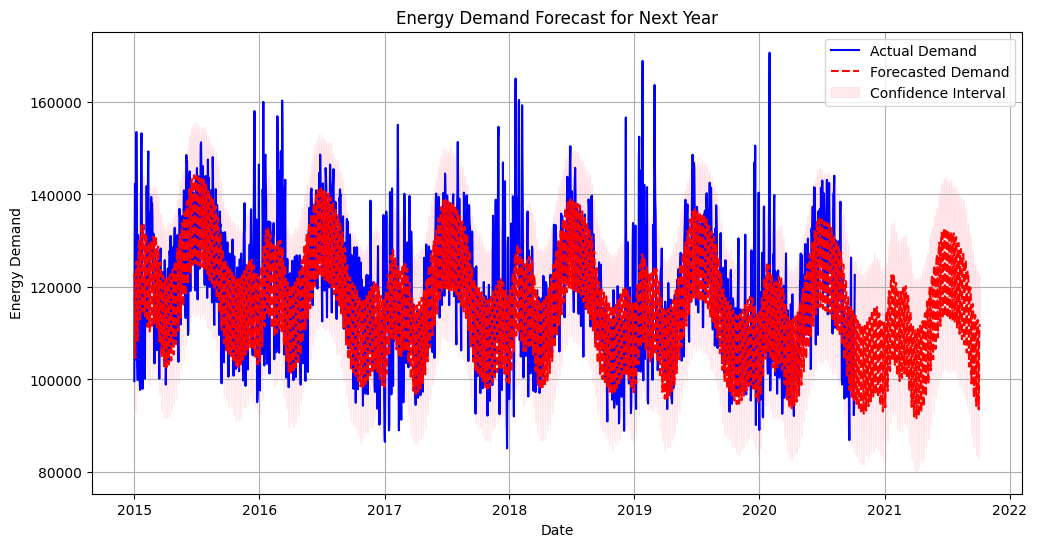

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet


# Load the dataset
file_path ="processed_dataset.csv"
df = pd.read_csv(file_path)

# Ensure correct column names for Prophet
df.rename(columns={'date': 'ds', 'demand': 'y'}, inplace=True)

# Convert 'ds' to datetime format
df['ds'] = pd.to_datetime(df['ds'])

# Train the Prophet model
model = Prophet()
model.fit(df)

# Create future dataframe for next 1 year
future = model.make_future_dataframe(periods=365, freq='D')

# Forecast
forecast = model.predict(future)

# Replot and save the forecast graph

plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label="Actual Demand", color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label="Forecasted Demand", color='red', linestyle='dashed')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3, label="Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Energy Demand")
plt.title("Energy Demand Forecast for Next Year")
plt.legend()
plt.grid()

# Save the plot
forecast_plot_path = "/mnt/data/forecast_plot.png"
plt.savefig(forecast_plot_path)

# Show the plot
plt.show()



In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,124565.528085,111343.387362,134539.882906,124565.528085,124565.528085,-1732.948611,-1732.948611,-1732.948611,5996.852732,5996.852732,5996.852732,-7729.801342,-7729.801342,-7729.801342,0.0,0.0,0.0,122832.579474
1,2015-01-02,124565.625597,110423.666666,132287.719315,124565.625597,124565.625597,-3446.619786,-3446.619786,-3446.619786,4057.642369,4057.642369,4057.642369,-7504.262155,-7504.262155,-7504.262155,0.0,0.0,0.0,121119.005811
2,2015-01-03,124565.723109,97614.188936,119762.321164,124565.723109,124565.723109,-16230.158669,-16230.158669,-16230.158669,-9012.456934,-9012.456934,-9012.456934,-7217.701735,-7217.701735,-7217.701735,0.0,0.0,0.0,108335.564440
3,2015-01-04,124565.820621,92798.495198,115677.420097,124565.820621,124565.820621,-19922.579639,-19922.579639,-19922.579639,-13051.082860,-13051.082860,-13051.082860,-6871.496779,-6871.496779,-6871.496779,0.0,0.0,0.0,104643.240982
4,2015-01-05,124565.918132,109352.787644,130567.887273,124565.918132,124565.918132,-4671.809238,-4671.809238,-4671.809238,1796.387443,1796.387443,1796.387443,-6468.196682,-6468.196682,-6468.196682,0.0,0.0,0.0,119894.108894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,2021-10-02,112533.740191,85904.922188,107840.918528,111265.909805,113788.430207,-14851.510480,-14851.510480,-14851.510480,-9012.456934,-9012.456934,-9012.456934,-5839.053546,-5839.053546,-5839.053546,0.0,0.0,0.0,97682.229711
2467,2021-10-03,112528.050737,82788.241203,104938.596741,111257.022015,113789.695232,-18973.120981,-18973.120981,-18973.120981,-13051.082860,-13051.082860,-13051.082860,-5922.038121,-5922.038121,-5922.038121,0.0,0.0,0.0,93554.929756
2468,2021-10-04,112522.361283,95794.515826,119319.359550,111245.972655,113790.960258,-4209.634021,-4209.634021,-4209.634021,1796.387443,1796.387443,1796.387443,-6006.021465,-6006.021465,-6006.021465,0.0,0.0,0.0,108312.727262
2469,2021-10-05,112516.671830,100549.593584,121711.764189,111234.923295,113792.225284,-1516.675118,-1516.675118,-1516.675118,4576.734604,4576.734604,4576.734604,-6093.409722,-6093.409722,-6093.409722,0.0,0.0,0.0,110999.996712


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpje50cd4_/m0zbupkw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpje50cd4_/f8fxp09o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44037', 'data', 'file=/tmp/tmpje50cd4_/m0zbupkw.json', 'init=/tmp/tmpje50cd4_/f8fxp09o.json', 'output', 'file=/tmp/tmpje50cd4_/prophet_modelln53k82k/prophet_model-20250313115638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:56:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:56:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-12-df4e7016bd45>:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ff

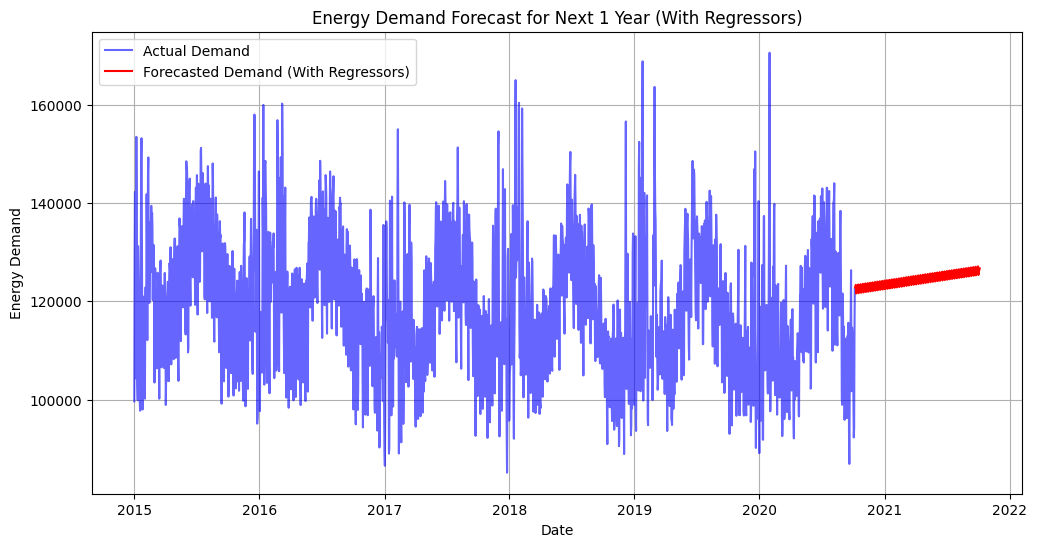

,ds,yhat
2106,2020-10-07,122857.670220
2107,2020-10-08,123107.142007
2108,2020-10-09,123356.569711
2109,2020-10-10,121604.048154
2110,2020-10-11,121853.405428


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

# Load the processed dataset
file_path = "processed_dataset.csv"
df = pd.read_csv(file_path)

# Ensure correct column names for Prophet
df.rename(columns={'date': 'ds', 'demand': 'y'}, inplace=True)

# Convert 'ds' to datetime format
df['ds'] = pd.to_datetime(df['ds'])

# Identify regressors
regressors = [col for col in df.columns if col not in ['ds', 'y']]

# Handle missing values and non-numeric values in regressors BEFORE fitting the model
for reg in regressors:
    # Impute missing values with 0 (or another suitable method)
    df[reg] = df[reg].fillna(0)
    # Convert non-numeric values to numeric (if possible)
    # Here, we're assuming 'N' represents 0 and other values are numeric
    df[reg] = pd.to_numeric(df[reg], errors='coerce').fillna(0)

# Train Prophet model with regressors
model_with_reg = Prophet()
for reg in regressors:
    model_with_reg.add_regressor(reg)

# Fit the model
model_with_reg.fit(df)

# Create future dataframe for next 1 year
future_with_reg = model_with_reg.make_future_dataframe(periods=365, freq='D')
future_with_reg = future_with_reg.merge(df[['ds'] + regressors], on='ds', how='left').fillna(method='ffill')

# Predict future demand
forecast_with_reg = model_with_reg.predict(future_with_reg)

# Extract forecast for the next 1 year
forecast_next_year = forecast_with_reg[['ds', 'yhat']].iloc[-365:]

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label="Actual Demand", color='blue', alpha=0.6)
plt.plot(forecast_next_year['ds'], forecast_next_year['yhat'], label="Forecasted Demand (With Regressors)", color='red')
plt.xlabel("Date")
plt.ylabel("Energy Demand")
plt.title("Energy Demand Forecast for Next 1 Year (With Regressors)")
plt.legend()
plt.grid()
plt.show()

# Display the forecasted demand values
forecast_next_year.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpje50cd4_/vd0h8gi2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpje50cd4_/_rhy92_c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86328', 'data', 'file=/tmp/tmpje50cd4_/vd0h8gi2.json', 'init=/tmp/tmpje50cd4_/_rhy92_c.json', 'output', 'file=/tmp/tmpje50cd4_/prophet_model4k7kpwsz/prophet_model-20250313121802.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:18:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:18:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


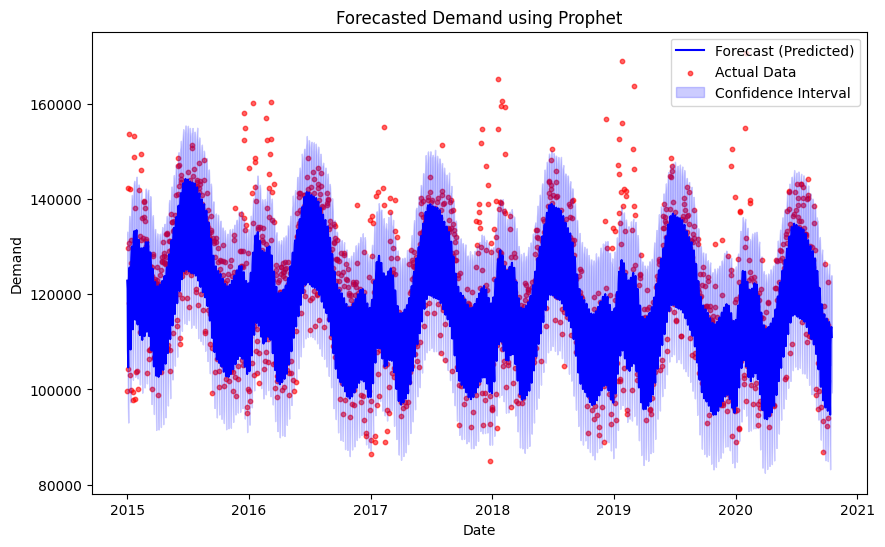

,ds,yhat,yhat_lower,yhat_upper
2106,2020-10-07,113905.514207,101582.193385,124477.621456
2107,2020-10-08,114150.443488,103010.808274,126350.623932
2108,2020-10-09,112086.188518,101749.829173,123537.504876
2109,2020-10-10,98881.882401,88276.036280,110367.728788
2110,2020-10-11,94700.227967,83258.420596,105057.006607
2111,2020-10-12,109396.623211,98483.260506,121035.287629
2112,2020-10-13,112019.022527,100685.449718,122976.677021
2113,2020-10-14,112914.915982,101873.952290,123835.669703
2114,2020-10-15,113109.027949,101361.098263,123982.615428
2115,2020-10-16,111001.534319,99366.948779,122112.806863


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

# Load the dataset
file_path = "processed_dataset.csv"
df = pd.read_csv(file_path)

# Ensure correct column names for Prophet
df.rename(columns={'date': 'ds', 'demand': 'y'}, inplace=True)

# Convert 'ds' to datetime format
df['ds'] = pd.to_datetime(df['ds'])

def forecast_demand(days):
    """
    Forecast energy demand for a user-defined number of future days using Prophet.

    Parameters:
    days (int): Number of days to forecast.

    Returns:
    forecast_df (DataFrame): Forecasted demand for the given number of days.
    """
    # Initialize Prophet model
    model = Prophet()
    model.fit(df)

    # Create future dataframe
    future = model.make_future_dataframe(periods=days, freq='D')

    # Forecast
    forecast = model.predict(future)

    # Plot the forecast
    # Removed unexpected indentation here
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(forecast['ds'], forecast['yhat'], color='blue', label='Forecast (Predicted)')
    ax.scatter(df['ds'], df['y'], color='red', label='Actual Data', alpha=0.6, s=10)  # red dots for actual values
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Confidence Interval')

    # Labels & Title
    ax.set_xlabel("Date")
    ax.set_ylabel("Demand")
    ax.set_title("Forecasted Demand using Prophet")

    # Add legend
    ax.legend()

    # Show the graph
    plt.show()


    # Return only the future predictions
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-days:]

# Example: Forecast for the next 10 days
forecast_demand(10)